# Starter use case: Predict flight delays

Version Date: November 2023

## Overview

This accelerator aims to assist DataRobot trial users by providing a guided walkthough of the trial experience. DataRobot suggests that you complete the Flight Delays sample use case in the graphical user interface first, and then return to this accelerator. 

In this notebook, you will:

 * Create a use case folder.
 * Import data from an S3 bucket (this differs from the in-software walkthrough tutorial).
 * Perform a data wrangling operation to create the target feature with code (this also differs from the in-software walkthrough tutorial).
 * Register the wrangled data set.
 * Explore the new data set.
 * Create an experiment and allow DataRobot automation to populate it with many modeling pipelines.
 * Explore model insights for the best performing model.
 * View the modeling pipeline for the best performing model.
 * Register a model in the Model Registry.
 * Configure a deployment.
 * Create a deployment.
 * Make predictions using the deployment.
 * Review deployment metrics.


### Data source

Information on flight delays is made available by the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/ONTIME/Departures.aspx). DataRobot downloaded data from this website in April 2023 and made minor modifications to prepare it for use in this accelerator. 

To narrow down the amount of data involved, the dataset assembled for this use case is limited to January 2023 flights originating in Portland (PDX) and Seattle (SEA) operated by the carriers Alaska Airlines (AS) and United Airlines (UA). 

### Data contents
  
There 7671 rows in the training data set with these 15 columns:

| Field                      | Data Type         | Description                                                                                           |
| -------------------------- | ----------------- | ----------------------------------------------------------------------------------------------------- |
| Date                       | str (MM/DD/YYYY) | The date of the flight.                                                                                |
| Carrier Code               | categorical       | The carrier code of the airline (one of AS, UA).                                               |
| Origin Airport             | categorical       | The three-letter airport code of the origin airport (one of PDX, SEA).                            |
| Flight Number              | numeric           | The flight number for the flight (needs to be converted to categorical).                               |
| Tail Number                | categorical       | The tail number of the aircraft.                                                                       |
| Destination Airport        | categorical       | The three-letter airport code of the destination airport (many variants).                              |
| Scheduled Departure Time   | time (HH:MM)      | The 24-hour scheduled departure time of the flight, in the origin airport's timezone.                  |
| Take-Off Delay Minutes     | numeric           | The number of minutes past the scheduled departure time that the flight took off (also known as wheels-up time). |
 


## Setup

### Import libraries

The first cell of the notebook imports necessary packages, and sets up the connection to the DataRobot platform. This accelerator uses Use Cases to organize related AI assets into a folder. Use Cases was added to the DataRobot Python package in version 3.2.0. 

In [1]:
import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
print(dr.__version__)

3.2.1


In [3]:
# Upgrade datarobot package to at least 3.2.0
# pip install --upgrade datarobot

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).
 

In [4]:
# Connect to DataRobot when using DataRobot Notebooks
dr.Client()

In [5]:
# Connect to DataRobot when working outside DataRobot Notebooks
# api_key = "YOUR_API_TOKEN"  # Get this from the Developer Tools page in the DataRobot UI
# endpoint = "YOUR_DATAROBOT_BASE_URL"  # eg "https://app.datarobot.com/" This should be the URL you use to access the DataRobot UI

# dr.Client(endpoint="%sapi/v2" % (endpoint), token=api_key)

In [6]:
# or use a config file
# dr.Client(config_path = "/Users/andrea.kropp/datarobot_ee_account_config.yaml")

## Create a new Use Case

Create a new use case folder to contain the assets that this accelerator will produce. This notebook will create three datasets, one experiment and one deployment inside the use case folder.

In [7]:
# Create a use case folder

flight_delays_use_case = dr.UseCase.create(
    name="Final Flight Delays Walkthrough from Notebook",
    description="Tutorial for understanding end-to-end workflows in DataRobot.",
)

flight_delays_use_case.id

'6543e9d18115b2f028fe6bd9'

## Retrieve the data

The data for this use case is provided in DataRobot's Amazon S3 public datasets bucket. There is a 300 KB CSV file used to train the model and a 31 KB CSV file used for performing a batch scoring job.

You can download the data to inspect it or add it directly to DataRobot's AI Catalog as shown in this notebook. The datasets can be added to AI Catalog directly from the Amazon S3 bucket.

[Download the training data (optional)](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/flight_delays/flight_delays_training.csv) 

[Download the scoring data (optional](https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/flight_delays/flight_delays_scoring.csv) 

### Upload data to DataRobot 

The datasets can be added to AI Catalog directly from the Amazon S3 bucket. After they are added, associate them with the current Use Case.

In [8]:
training_data = dr.Dataset.upload(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/flight_delays/flight_delays_training.csv"
)
training_data.id

'6543e9d18115b2f028fe6bdb'

In [9]:
scoring_data = dr.Dataset.upload(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/flight_delays/flight_delays_scoring.csv"
)
scoring_data.id

'6543ea10134c85fe7808bba3'

In [10]:
# Add the two datasets to the use case

flight_delays_use_case.add(entity=training_data)
flight_delays_use_case.add(entity=scoring_data)
flight_delays_use_case.list_datasets()

[Dataset(name='flight_delays_scoring.csv', id='6543ea10134c85fe7808bba3'),
 Dataset(name='flight_delays_training.csv', id='6543e9d18115b2f028fe6bdb')]

## Explore and wrangle the data

Access the dataset that has been uploaded to AI Catalog and convert it to a pandas dataframe. Then view the top few rows. Perform a calculation to create a new column. The new column will be used as the target for the binary classifier, so this step is required.

#### View dataset

In [11]:
# Retrieve the data set locally and convert it to a pandas dataframe
df = dr.Dataset.get(training_data.id).get_as_dataframe()
df.head(10)

,Date,Carrier_Code,Origin_Airport,Flight_Number,Tail_Number,Destination_Airport,Scheduled_Departure_Time,Take_Off_Delay_Minutes
0,1/1/23,UA,SEA,2090,N79521,ORD,0:29,3
1,1/1/23,AS,SEA,185,N408AS,ANC,0:30,75
2,1/1/23,UA,SEA,2672,N67501,DEN,5:03,3
3,1/1/23,UA,PDX,2493,N39423,DEN,5:05,8
4,1/1/23,AS,PDX,697,N237AK,SJC,6:00,12
5,1/1/23,AS,PDX,371,N533AS,LAX,6:00,-1
6,1/1/23,AS,SEA,257,N926VA,LAX,6:00,9
7,1/1/23,AS,SEA,1014,N260AK,ORD,6:00,15
8,1/1/23,AS,SEA,74,N618AS,SNA,6:00,-1
9,1/1/23,UA,SEA,1771,N35271,ORD,6:24,4


Text(0.5, 0, 'Flight Count')

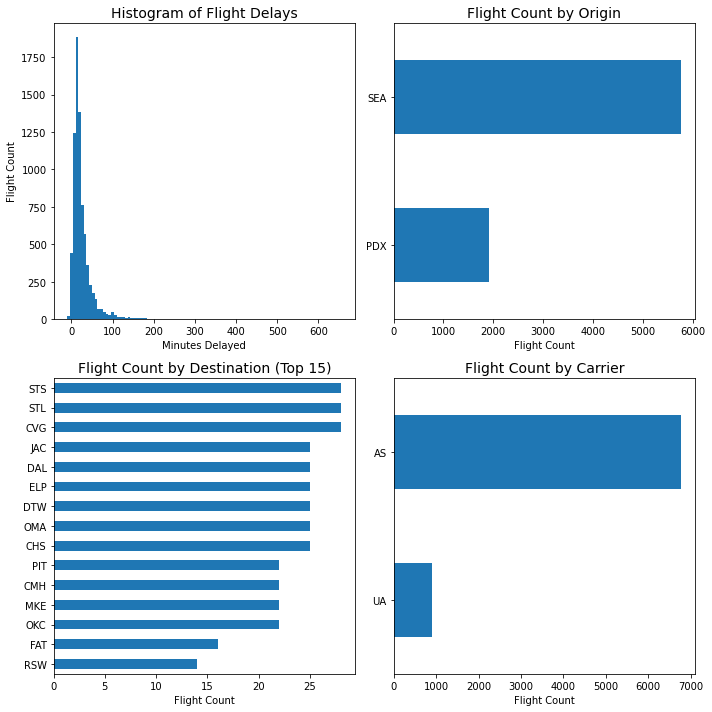

In [12]:
# Explore the data provided with some plots

plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["figure.titlesize"] = 14

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)

plt.subplot(2, 2, 1)
plt.hist(df["Take_Off_Delay_Minutes"], bins=100)
plt.title(
    "Histogram of Flight Delays",
)
plt.ylabel("Flight Count")
plt.xlabel("Minutes Delayed")

plt.subplot(2, 2, 2)
df["Origin_Airport"].value_counts().sort_values().plot(kind="barh")
plt.title("Flight Count by Origin")
plt.xlabel("Flight Count")

plt.subplot(2, 2, 3)
df["Destination_Airport"].value_counts().sort_values()[0:15].plot(kind="barh")
plt.title("Flight Count by Destination (Top 15)")
plt.xlabel("Flight Count")

plt.subplot(2, 2, 4)
df["Carrier_Code"].value_counts().sort_values().plot(kind="barh")
plt.title("Flight Count by Carrier")
plt.xlabel("Flight Count")

### Perform one data wrangling operation

The training data contains the flight delay in minutes with the feature name `TAKE_OFF_DELAY_MINUTES`. Compute a new binary feature to indicate if the delay is greater than 30 minutes named `TAKE_OFF_DELAY_GREATER_THAN_30`.

In [13]:
# Calculate whether the delay exceeds 30 minutes
df["TAKE_OFF_DELAY_GREATER_THAN_30"] = np.where(df["Take_Off_Delay_Minutes"] > 30, 1, 0)

# Calculate the percentage of all flights delayed by more than 30 minutes
np.mean(df["TAKE_OFF_DELAY_GREATER_THAN_30"])

0.24172099087353324

In [14]:
# Add the wrangled data to the Use Case; obtain the unique identifier for the dataset

df_final = dr.Dataset.create_from_in_memory_data(
    data_frame=df, use_cases=flight_delays_use_case, fname="flight delays wrangled"
)
df_final.id

'6543ea4e36f70a91d0700201'

## Create an Experiment

To create an experiment project from a dataset, use `create_from_dataset()`.

Start a new project and obtain its ID number for future reference. If you wish, you can open the DataRobot graphical user interface and you'll see a new Experiment project listed after you execute the next cell.

In [15]:
# Create a new experiment project from a previously registered dataset
# Place the project in the same use case folder

project = dr.Project.create_from_dataset(
    df_final.id,
    project_name="Flight Delays Walkthrough Experiments",
    use_case=flight_delays_use_case,
)
project.id

'6543ea8335cacd9d5d4703d4'

### Start modeling

The project is ready to start modeling. There are numerous configurable settings which are out of scope of this accelerator. Visit the [DataRobot documentation](https://docs.datarobot.com/en/docs/modeling/index.html) to learn more about advanced options, modeling modes, worker counts and selecting an optimization metric.

You can optionally open the DataRobot GUI to see a new experiment listed after you execute the next cell.

In [16]:
# Start modeling. Once you execute this, the initial settings can no longer be changed.
project.analyze_and_model(target="TAKE_OFF_DELAY_GREATER_THAN_30")

# You can optionally open the DataRobot GUI to see the modeling in progress.
project.wait_for_autopilot(timeout=3600)

In progress: 8, queued: 1 (waited: 0s)
In progress: 8, queued: 1 (waited: 1s)
In progress: 8, queued: 1 (waited: 2s)
In progress: 8, queued: 1 (waited: 3s)
In progress: 8, queued: 1 (waited: 4s)
In progress: 8, queued: 1 (waited: 6s)
In progress: 8, queued: 1 (waited: 10s)
In progress: 8, queued: 1 (waited: 18s)
In progress: 8, queued: 1 (waited: 31s)
In progress: 4, queued: 0 (waited: 52s)
In progress: 2, queued: 0 (waited: 73s)
In progress: 2, queued: 0 (waited: 94s)
In progress: 1, queued: 0 (waited: 115s)
In progress: 7, queued: 9 (waited: 136s)
In progress: 8, queued: 8 (waited: 157s)
In progress: 7, queued: 2 (waited: 178s)
In progress: 7, queued: 0 (waited: 199s)
In progress: 2, queued: 0 (waited: 220s)
In progress: 0, queued: 0 (waited: 241s)
In progress: 0, queued: 0 (waited: 262s)
In progress: 1, queued: 0 (waited: 282s)
In progress: 1, queued: 0 (waited: 303s)
In progress: 1, queued: 0 (waited: 324s)
In progress: 1, queued: 0 (waited: 345s)
In progress: 0, queued: 0 (waited:

## Examine Experiment contents and explore the top model

List all the models that have been created within the project. Then you can learn more about the top performing model.

In [17]:
# Get all the models for the project. The top model for the optimization metric on the validation set is the first one.
models = project.get_models()
models

[Model('RuleFit Classifier'),
 Model('RuleFit Classifier'),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('RandomForest Classifier (Gini)'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Generalized Additive2 Model'),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)')]

In [18]:
# Retrieve the model object for the top performing model. Select one of the models to examine more closely.
# Note that model comparison is better conducted in the graphical user interface.

top_model = project.get_top_model(metric="LogLoss")
top_model.id

'6543eacc46dd8c49b326ae86'

In [19]:
# Print the LogLoss and AUC for the top model
f"The top model is a {top_model.model_type} with a Log Loss of {top_model.metrics['LogLoss']['crossValidation']} and an AUC of {top_model.metrics['AUC']['crossValidation']}."

'The top model is a RuleFit Classifier with a Log Loss of 0.521166 and an AUC of 0.664088.'

### Feature Impact

Learn about the features used in the top performing model and visualize which features are driving model decisions.

In [20]:
# Get Feature Impact for the top model
feature_impact = top_model.get_or_request_feature_impact()

# Save feature impact in a pandas dataframe
fi_df = pd.DataFrame(feature_impact)

fi_df

,featureName,impactNormalized,impactUnnormalized,redundantWith
0,Date,1.000000,0.023229,None
1,Scheduled_Departure_Time,0.949682,0.022060,None
2,Flight_Number,0.591023,0.013729,None
3,Date (Day of Week),0.548815,0.012748,None
4,Origin_Airport,0.506295,0.011761,None
5,Destination_Airport,0.397192,0.009226,None
6,Scheduled_Departure_Time (Hour of Day),0.260896,0.006060,None
7,Carrier_Code,0.036059,0.000838,None
8,Tail_Number,0.000000,0.000000,None


### Blueprint

See the full machine leanring pipeline for the top model including preprocessing steps.

In [21]:
# Retrieve the blueprint of the top model
blueprint = dr.Blueprint.get(project.id, top_model.blueprint_id)

print(blueprint.processes)

['One-Hot Encoding', 'Missing Values Imputed', 'Matrix of word-grams occurrences', 'RuleFit Classifier']


## Register the model

Register the top model in the Model Registry. This will be possible with future versions of the DataRobot Python package.

## Deploy the model

Deploy the model to a DataRobot prediction server.

In [22]:
# The default prediction server is used when making predictions against the deployment, and is a requirement for creating a deployment on DataRobot cloud.
prediction_server = dr.PredictionServer.list()[0]
prediction_server

PredictionServer(https://mlops.dynamic.orm.datarobot.com)

In [23]:
# Create a new deployment

deployment = dr.Deployment.create_from_learning_model(
    top_model.id,
    label="Flight Delays Deployment",
    description="Deployment from notebook of top model",
    default_prediction_server_id=prediction_server.id,
)

deployment.id

'6543ec6e6fcffd7022f1cf12'

In [24]:
# Update deployment settings to enable draft tracking

deployment.update_drift_tracking_settings(
    target_drift_enabled=True, feature_drift_enabled=True
)

## Make batch predictions

Make predictions using the scoring dataset. There are many options for how to score new data. Read about all your [choices for making predictions](https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.2.1/reference/predictions/batch_predictions.html).

In [35]:
# Option 1: Score an in-memory Pandas DataFrame.

scoring_df = dr.Dataset.get(scoring_data.id).get_as_dataframe()
scoring_df.head(5)

,Date,Carrier_Code,Origin_Airport,Flight_Number,Tail_Number,Destination_Airport,Scheduled_Departure_Time
0,1/29/23,UA,SEA,529,N27724,IAH,5:00
1,1/29/23,UA,PDX,2075,N466UA,IAH,5:04
2,1/29/23,UA,SEA,2672,N808UA,DEN,5:15
3,1/29/23,UA,PDX,2493,N463UA,DEN,5:30
4,1/29/23,UA,SEA,1780,N37536,SFO,5:30


In [36]:
# The method returns a copy of the job status and the updated DataFrame with the predictions added.
# So your DataFrame will now contain the following extra columns:

job, scoring_df = dr.BatchPredictionJob.score_pandas(deployment.id, scoring_df)

scoring_df.head(5)

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 6543edb01cd1acb572c6059c
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


,Date,Carrier_Code,Origin_Airport,Flight_Number,Tail_Number,Destination_Airport,Scheduled_Departure_Time,TAKE_OFF_DELAY_GREATER_THAN_30_1_PREDICTION,TAKE_OFF_DELAY_GREATER_THAN_30_0_PREDICTION,TAKE_OFF_DELAY_GREATER_THAN_30_PREDICTION,THRESHOLD,POSITIVE_CLASS,DEPLOYMENT_APPROVAL_STATUS
0,1/29/23,UA,SEA,529,N27724,IAH,5:00,0.145428,0.854572,0,0.5,1,APPROVED
1,1/29/23,UA,PDX,2075,N466UA,IAH,5:04,0.063791,0.936209,0,0.5,1,APPROVED
2,1/29/23,UA,SEA,2672,N808UA,DEN,5:15,0.093707,0.906293,0,0.5,1,APPROVED
3,1/29/23,UA,PDX,2493,N463UA,DEN,5:30,0.060908,0.939092,0,0.5,1,APPROVED
4,1/29/23,UA,SEA,1780,N37536,SFO,5:30,0.144848,0.855152,0,0.5,1,APPROVED


## Review deployment metrics

Having scored some data, you can now view the monitoring metrics associated with the deployment. Learn about all [monitoring metrics associated with the Deployment](https://datarobot-public-api-client.readthedocs-hosted.com/en/v3.2.1/reference/mlops/deployment.html?highlight=service%20health#monitoring)

In [ ]:
# Wait a few seconds to be sure that monitoring metrics will be available when requested
import time

time.sleep(15)  # Sleep for 15 seconds

In [38]:
# Returns the total number of predictions made

from datarobot.enums import SERVICE_STAT_METRIC

service_stats = deployment.get_service_stats()

service_stats[SERVICE_STAT_METRIC.TOTAL_PREDICTIONS]

1648

In [39]:
# Returns the drift in the target feature

from datarobot.enums import DATA_DRIFT_METRIC

target_drift = deployment.get_target_drift()
target_drift.drift_score

0.41781727459845186

In [40]:
# Retrieves drift metrics for features other than the target

feature_drift_data = deployment.get_feature_drift()

feature_drift_data

[FeatureDrift(6543eacc46dd8c49b326ae86 | Flight_Number | 2023-10-26 19:00:00+00:00 - 2023-11-02 19:00:00+00:00),
 FeatureDrift(6543eacc46dd8c49b326ae86 | Date (Day of Week) | 2023-10-26 19:00:00+00:00 - 2023-11-02 19:00:00+00:00),
 FeatureDrift(6543eacc46dd8c49b326ae86 | Origin_Airport | 2023-10-26 19:00:00+00:00 - 2023-11-02 19:00:00+00:00),
 FeatureDrift(6543eacc46dd8c49b326ae86 | Destination_Airport | 2023-10-26 19:00:00+00:00 - 2023-11-02 19:00:00+00:00),
 FeatureDrift(6543eacc46dd8c49b326ae86 | Scheduled_Departure_Time (Hour of Day) | 2023-10-26 19:00:00+00:00 - 2023-11-02 19:00:00+00:00),
 FeatureDrift(6543eacc46dd8c49b326ae86 | Carrier_Code | 2023-10-26 19:00:00+00:00 - 2023-11-02 19:00:00+00:00),
 FeatureDrift(6543eacc46dd8c49b326ae86 | Tail_Number | 2023-10-26 19:00:00+00:00 - 2023-11-02 19:00:00+00:00)]

In [41]:
# View first feature name and drift

feature_drift = feature_drift_data[1]

f"The feature {feature_drift.name} has drift by {feature_drift.drift_score}"

'The feature Date (Day of Week) has drift by 3.176396672912841'